# Imports

In [1]:
import math
import os
import time
from typing import Callable, Dict

from os import path

# # Analysis
# import geopandas as gpd
# from pysal.explore import esda
# from pysal.lib import weights
# from libpysal.weights import DistanceBand
# from numpy.random import seed

import joblib
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
from loguru import logger
import re

from pandas import IndexSlice, MultiIndex
import itertools

from geo_kpe_multidoc import (GEO_KPE_MULTIDOC_CACHE_PATH,
                              GEO_KPE_MULTIDOC_DATA_PATH,
                              GEO_KPE_MULTIDOC_OUTPUT_PATH)


from geo_kpe_multidoc.geo.measures import (inv_dist,
                                           exp_dist,
                                           arc_dist,
                                           )

from geo_kpe_multidoc.geo.utils import process_geo_associations_for_topics

from geo_kpe_multidoc.datasets.process_mordecai import load_topic_geo_locations

In [2]:
def print_latex(df, caption=None):
    print(df.style
            .format(precision=2, escape="latex")
            .format_index(escape="latex")
            .format_index(lambda s: s.replace("_", " ").capitalize(), axis=1)
            .to_latex(hrules=True, 
                      environment='table', 
                      position_float="centering",
                      # clines = "all;data",
                      caption=caption))

def print_fig_latex(filename, caption="Caption", label='label'):
    print(f"""\\begin{{figure}}
    \centering
    \includegraphics[width=\\textwidth]{{fig/{filename}}}
    \caption{{{caption}}}
    \label{{fig:{label}}}
    \end{{figure}}
    """)

def plot_dist(df, idx_filter, title = None, bins = 20, column='moran_i', by='gold'):
    p = sb.histplot(
        df.loc[idx_filter]
          .groupby(by, group_keys=False)
          .apply(lambda x: x.sample(min(len(x), min(np.unique(df.loc[idx_filter][by], return_counts=True)[1]))).sample(frac=1)),
        x=column, hue=by, bins=bins
    )
    p.set_title(title)
    return p

def save_plot(p, name, caption="Caption", label="label"):
    p.get_figure().savefig(os.path.join(GEO_KPE_MULTIDOC_OUTPUT_PATH, name), dpi=100)
    print_fig_latex(name, caption, label)
    return p

def add_gold_label(df, gold):
    """
    Mutate dataframe `df` adding a label column if candidate is in the gold set.
    """
    gold_idx = MultiIndex.from_tuples(
    itertools.chain.from_iterable(
        df.index[df.index.isin([topic], level=0) 
                    & df.index.isin(gold[topic], level=1)] 
        for topic in df.index.get_level_values(0).unique()
    ),
    names=['topic', 'keyphrases']
    )

    not_gold_idx = MultiIndex.from_tuples(
    itertools.chain.from_iterable(
          df.index[df.index.isin([topic], level=0)
                      & ~df.index.isin(gold[topic], level=1)] 
          for topic in df.index.get_level_values(0).unique()
      ),
      names=['topic', 'keyphrases']
    )

    df.loc[gold_idx, "gold"] = True
    df.loc[not_gold_idx, "gold"] = False

# MDKPERank

In [4]:
def get_files(path: str):
    geo_file_name_pattern = re.compile(r"d\d{2}-mdkpe-geo\.pkl")
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)) and geo_file_name_pattern.match(file):
            yield file

In [ ]:
# data = pd.DataFrame()
# docs_data = pd.DataFrame()
# # DELETE coordinates = {}
# gold = {}

# experiment = "20230327"

# for filename in get_files(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment)):
#     topic_id = filename[:3]

#     if topic_id in ["d08",  # errors
#             "d14",
#             "d22",
#             "d28",
#             "d34",
#             "d50",
#             "d53",
#             "d59",]:
#             logger.info(f"Skiping topic {topic_id} processing.")
#             continue


#     (
#         keyphrase_scores,
#         candidates,
#         keyphrase_document_matrix,
#         # keyphrase_coordinates,
#         ranking_p_doc, # new
#         gold_kp,
#     ) = joblib.load(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, filename))

#     N = {candidate: len(docs) for candidate, docs in keyphrase_document_matrix.items()}

#     keyphrase_scores = {candidate: score for candidate, score in keyphrase_scores}

#     topic_docs_data = pd.DataFrame.from_dict(
#         {
#             doc_id: {
#                 candidate: float(score) for candidate, score in candidate_ranking
#             }
#             for doc_id, (candidate_ranking, _) in ranking_p_doc.items()
#         }, 
#         orient="index"
#     ).stack()
#     topic_docs_data.name = "semantic_score"
#     topic_docs_data = topic_docs_data.to_frame()
#     topic_docs_data.index.names = ("doc", "keyphrase")
#     topic_docs_data["topic"] = topic_id
#     topic_docs_data = topic_docs_data.set_index(["topic", topic_docs_data.index])

#     topic_data = pd.DataFrame.from_dict(
#         keyphrase_scores, orient="index", columns=["semantic_score"]
#     )
#     topic_data["N"] = pd.DataFrame.from_dict(N, orient="index", columns=["N"])
#     topic_data["topic"] = topic_id
#     topic_data.index.name = "keyphrase"
#     topic_data = topic_data.set_index(["topic", topic_data.index])

#     # coordinates[topic_id] = keyphrase_coordinates
#     gold[topic_id] = gold_kp

#     docs_data = pd.concat([docs_data, topic_docs_data])
#     data = pd.concat([data, topic_data])

# joblib.dump(gold, os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-gold-20230328.pkl"))
# docs_data.to_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-docs-data-20230328.parquet"))
# data.to_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-topic-data-20230328.parquet"))

In [6]:
experiment = "MKDUC01-MDKPERank-Longformer-4096-128-130"

In [ ]:
global_topic_data = pd.DataFrame()
docs_data = pd.DataFrame()
topic_candidate_document_matrix = dict()
gold = dict()

for filename in get_files(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment)):
    topic_id = filename[:3]

    if topic_id in ["d08",  # errors
            "d14",
            "d22",
            "d28",
            "d34",
            "d50",
            "d53",
            "d59",]:
            logger.info(f"Skiping topic {topic_id} processing.")
            continue

    # {
    #     "top_n_scores": top_n_scores,
    #     "score_per_document": score_per_document,
    #     "candidate_document_matrix": candidate_document_matrix,
    #     "gold_kp": gold_kp,
    # }
    topic_results = joblib.load(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, filename))

    N = topic_results["candidate_document_matrix"].sum(axis=1)

    topic_docs_data = topic_results["score_per_document"].melt(var_name='document', value_name='semantic_score', ignore_index=False)
    topic_docs_data["topic"] = topic_id
    topic_docs_data.index.name = "keyphrase"
    topic_docs_data = topic_docs_data.set_index(["topic", "document", topic_docs_data.index])
    topic_docs_data

    topic_data = pd.DataFrame(topic_results["top_n_scores"], columns=["semantic_score"])
    topic_data["N"] = N
    topic_data["topic"] = topic_id
    topic_data.index.name = "keyphrase"
    topic_data = topic_data.set_index(["topic", topic_data.index])

    # coordinates[topic_id] = keyphrase_coordinates
    gold[topic_id] = topic_results["gold_kp"]
    topic_candidate_document_matrix[topic_id] = topic_results["candidate_document_matrix"]
    docs_data = pd.concat([docs_data, topic_docs_data])
    global_topic_data = pd.concat([global_topic_data, topic_data])

joblib.dump(topic_candidate_document_matrix, os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-topic-cand-doc-matrix-20230501.pkl"))
joblib.dump(gold, os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-gold-20230501.pkl"))
docs_data.to_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-docs-data-20230501.parquet"))
global_topic_data.to_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-topic-data-20230501.parquet"))

2023-05-01 16:56:02.434 | INFO     | __main__:<cell line: 6>:17 - Skiping topic d08 processing.
2023-05-01 16:56:02.554 | INFO     | __main__:<cell line: 6>:17 - Skiping topic d14 processing.
2023-05-01 16:56:02.649 | INFO     | __main__:<cell line: 6>:17 - Skiping topic d22 processing.
2023-05-01 16:56:02.764 | INFO     | __main__:<cell line: 6>:17 - Skiping topic d28 processing.
2023-05-01 16:56:02.976 | INFO     | __main__:<cell line: 6>:17 - Skiping topic d34 processing.
2023-05-01 16:56:03.561 | INFO     | __main__:<cell line: 6>:17 - Skiping topic d50 processing.
2023-05-01 16:56:03.564 | INFO     | __main__:<cell line: 6>:17 - Skiping topic d53 processing.
2023-05-01 16:56:03.943 | INFO     | __main__:<cell line: 6>:17 - Skiping topic d59 processing.


# Plots



In [ ]:
# select d45 - document coordinates are more clustered
# select d57 - document coordinates are spread
d45 = IndexSlice['d45', :]
d57 = IndexSlice['d57', :]

<ipython-input-36-12c9bfd76fbc>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  topic_geo_data_24.loc[d45].hist(column='moran_i', by='gold', density=True, ax=ax)


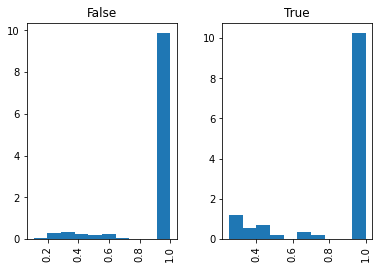

In [ ]:
fig, ax = plt.subplots(1)
topic_geo_data_24.loc[d45].hist(column='moran_i', by='gold', density=True, ax=ax)


array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

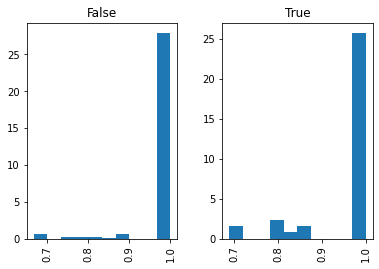

<Axes: xlabel='moran_i', ylabel='Count'>

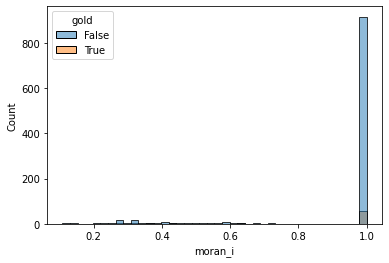

In [ ]:
sb.histplot(topic_geo_data_24.loc[d45], x="moran_i", hue="gold", bins=40)

\begin{figure}
    \centering
    \includegraphics[width=\textwidth]{fig/plt-dist-moran-i-d45-exp20230324.pdf}
    \caption{d45 - document coordinates are more clustered}
    \label{fig:label}
    \end{figure}
    


<Axes: xlabel='moran_i', ylabel='Count'>

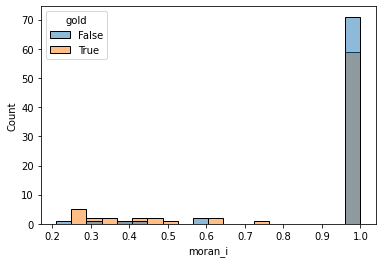

In [ ]:
save_plot(
    plot_dist(topic_geo_data_24, d45, title=None),
    name = "plt-dist-moran-i-d45-exp20230324.pdf",
    caption = "d45 - document coordinates are more clustered")

\begin{figure}
    \centering
    \includegraphics[width=\textwidth]{fig/plt-dist-moran-i-d57-exp20230324.pdf}
    \caption{d57 - document coordinates are spread}
    \label{fig:label}
    \end{figure}
    


<Axes: xlabel='moran_i', ylabel='Count'>

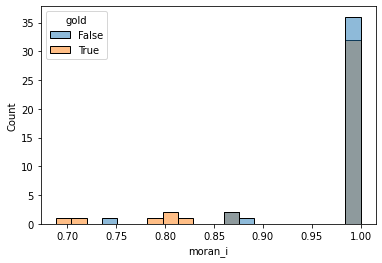

In [ ]:
save_plot(
    plot_dist(topic_geo_data_24, d57, title=None),
    name = "plt-dist-moran-i-d57-exp20230324.pdf",
    caption = "d57 - document coordinates are spread")

\begin{figure}
    \centering
    \includegraphics[width=\textwidth]{fig/plt-dist-moran-i-all-exp20230324.pdf}
    \caption{All topics}
    \label{fig:label}
    \end{figure}
    


<Axes: xlabel='moran_i', ylabel='Count'>

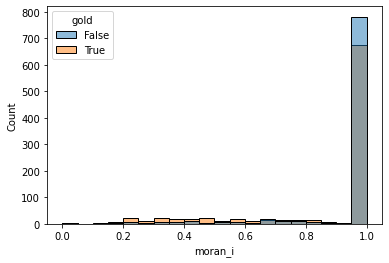

In [ ]:
save_plot(
    plot_dist(topic_geo_data_24, IndexSlice[:, :], title=None),
    name = "plt-dist-moran-i-all-exp20230324.pdf",
    caption = "All topics")

\begin{figure}
    \centering
    \includegraphics[width=\textwidth]{fig/plt-dist-Ngt1-all-exp20230324.pdf}
    \caption{All topics (only candidates in many docs N>1)}
    \label{fig:label}
    \end{figure}
    


<Axes: xlabel='moran_i', ylabel='Count'>

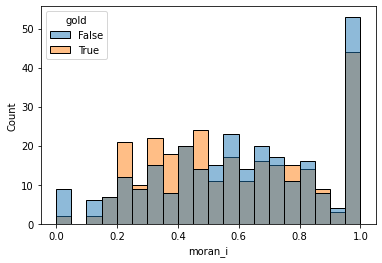

In [ ]:
save_plot(
    plot_dist(topic_geo_data_24[topic_geo_data_24["N"] > 1], IndexSlice[:, :], title=None),
    name = "plt-dist-Ngt1-all-exp20230324.pdf",
    caption = "All topics (only candidates in many docs N>1)")

\begin{figure}
    \centering
    \includegraphics[width=\textwidth]{fig/plt-dist-N-all-exp20230324.pdf}
    \caption{Number of documents where each candidate is present}
    \label{fig:label}
    \end{figure}
    


<Axes: xlabel='N', ylabel='Count'>

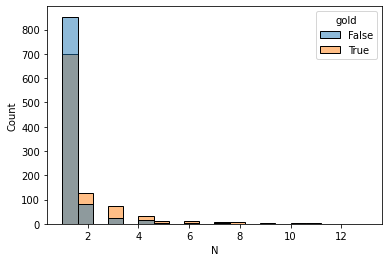

In [ ]:
save_plot(
    plot_dist(topic_geo_data_24, IndexSlice[:, :], column="N",  title=None),
    name = "plt-dist-N-all-exp20230324.pdf",
    caption = "Number of documents where each candidate is present")

<Axes: xlabel='N', ylabel='Count'>

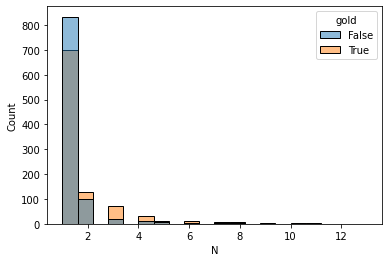

# Comparison Geo Association (inv_func, [a=1, a=17000])

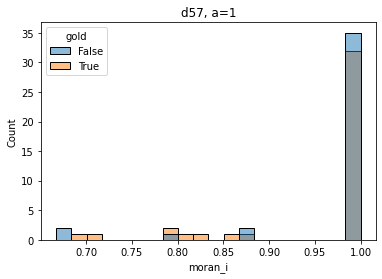

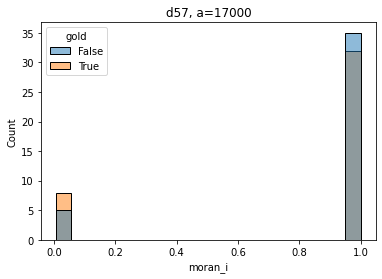

In [ ]:
#save_plot(
plot_dist(topic_geo_data_24, d57, title="d57, a=1")
plt.show()
#    name = "plt-dist-moran-i-d57-exp20230324.pdf",
#    caption = "d57 - document coordinates are spread")
plot_dist(topic_geo_data_inv_a17000, d57, title="d57, a=17000")
plt.show()

<Axes: xlabel='moran_i', ylabel='Count'>

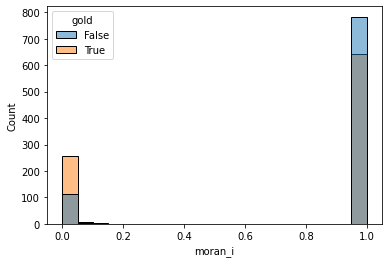

In [ ]:
plot_dist(topic_geo_data_inv_a17000, IndexSlice[:, :], title=None)

# Ad-hoc

In [3]:

experiment = "MKDUC01-MDKPERank-Longformer-4096-128-130"

docs_data = pd.read_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-docs-data-20230501.parquet"))
topic_data = pd.read_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH,  experiment, "MKDUC01-topic-data-20230501.parquet"))
topic_docs_coordinates = pd.read_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, "MKDUC01-topic-doc-coordinates-20230329.parquet"))
topic_candidate_document_matrix = joblib.load(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-topic-cand-doc-matrix-20230501.pkl"))

gold_24 = joblib.load(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-gold-20230501.pkl"))
add_gold_label(topic_data, gold_24)

In [7]:
d45 = IndexSlice['d45', :]
d57 = IndexSlice['d57', :]
df = topic_data.copy()

f_map = {
    "Inverse": inv_dist,
    "Exponential": exp_dist,
    "Arccot": arc_dist,
}

w_function = f_map['Inverse']
w_function_param = 500


process_geo_associations_for_topics(df, 
                                    docs_data,
                                    topic_candidate_document_matrix,
                                    doc_coordinate_data = topic_docs_coordinates,
                                    w_function = w_function, 
                                    w_function_param = w_function_param, 
                                    save_cache=False)

semantic_score  N   gold  moran_i  geary_c  \
topic keyphrase                                                                
d04   disaster loss                     0.708538  1   True      1.0      0.0   
      industry dollar                   0.703703  1  False      1.0      0.0   
      catastrophe                       0.699115  1  False      1.0      0.0   
      insurance industry analyst        0.698589  1  False      1.0      0.0   
      catastrophe loss                  0.698325  1  False      1.0      0.0   
...                                          ... ..    ...      ...      ...   
d57   window                            0.128975  1  False      1.0      0.0   
      day session                       0.118611  1  False      1.0      0.0   
      randall updike                    0.091626  1  False      1.0      0.0   
      corner                            0.091019  1  False      1.0      0.0   
      shirt                             0.045794  1  False      1.0      0.0   

                                   getis_g  
topic keyphrase                             
d04   disaster loss               0.071429  
      industry dollar             0.071429  
      catastrophe                 0.111111  
      insurance industry analyst  0.071429  
      catastrophe loss            0.111111  
...                                    ...  
d57   window                      0.166667  
      day session                 0.166667  
      randall updike              0.166667  
      corner                      0.166667  
      shirt                       0.166667  

[20751 rows x 6 columns]

<AxesSubplot:title={'center':'inv_dist, a = 1000, All topics'}, xlabel='moran_i', ylabel='Count'>

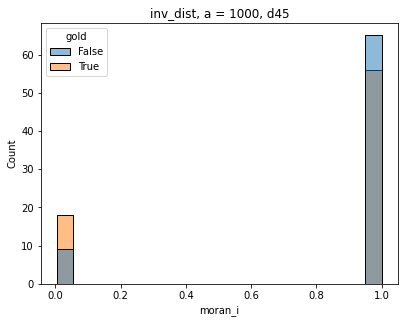

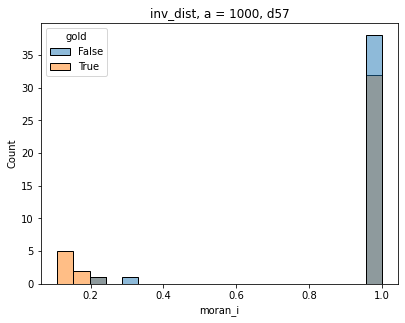

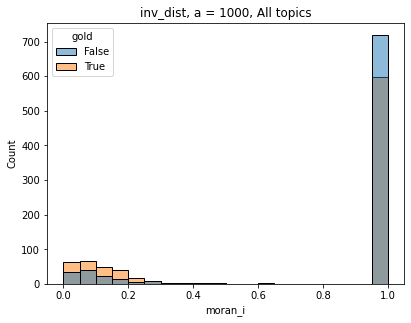

In [6]:
plt.rcParams['figure.figsize'] = (6.4, 4.8)
    
fig1 = plt.figure(1)
fig1.add_subplot(
    plot_dist(df, d45, title=f"{w_function.__name__}, a = {w_function_param}, d45")
)

fig2 = plt.figure(2)
fig2.add_subplot(
    plot_dist(df, d57, title=f"{w_function.__name__}, a = {w_function_param}, d57")
)


fig3 = plt.figure(3)
fig3.add_subplot(
    plot_dist(df, IndexSlice[:, :], title=f"{w_function.__name__}, a = {w_function_param}, All topics")
)

In [ ]:
topic_geo_data_adhoc = pd.read_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH,  "MKDUC01", "geo-measures-exp_dist-1-20230324-224344.parquet"))
add_gold_label(topic_geo_data_adhoc, gold_24)

In [ ]:
plot_dist(topic_geo_data_adhoc, IndexSlice[:, :], title=None)
# a = 10

In [ ]:
# geo-measures-inv_dist-100-20230329-111642
# a = 100
plot_dist(topic_geo_data_adhoc, IndexSlice[:, :], title=None)

In [ ]:
# geo-measures-inv_dist-1000-20230329-111757
# a = 1000
plot_dist(topic_geo_data_adhoc, IndexSlice[:, :], title=None)

In [ ]:
plot_dist(topic_geo_data_adhoc, IndexSlice[:, :], title=None)
# a = 1000

In [ ]:
# geo-measures-exp_dist-1-20230324-224344
plot_dist(topic_geo_data_adhoc, IndexSlice[:, :], title=None)

In [ ]:
# geo-measures-exp_dist-0.1-20230324-223915
plot_dist(topic_geo_data_adhoc, d57, title=None)

In [ ]:
plot_dist(topic_geo_data_adhoc, d57, title=None)
plt.xlim = (0, 1)

In [ ]:
topic_geo_data_adhoc.loc[d57].hist(column='moran_i', by='gold', density=True)

# Gradio APP

In [7]:
experiment = "MKDUC01-MDKPERank-Longformer-4096-128-130"

In [8]:
docs_data = pd.read_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-docs-data-20230501.parquet"))
topic_data = pd.read_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH,  experiment, "MKDUC01-topic-data-20230501.parquet"))
topic_docs_coordinates = pd.read_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, "MKDUC01-topic-doc-coordinates-20230329.parquet"))
topic_candidate_document_matrix = joblib.load(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-topic-cand-doc-matrix-20230501.pkl"))

gold_24 = joblib.load(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment, "MKDUC01-gold-20230501.pkl"))
add_gold_label(topic_data, gold_24)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


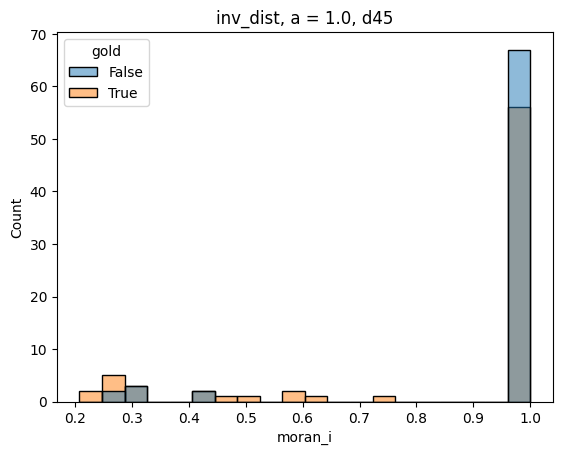

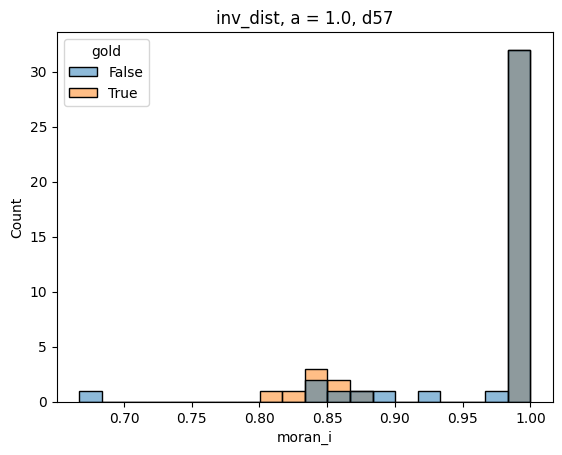

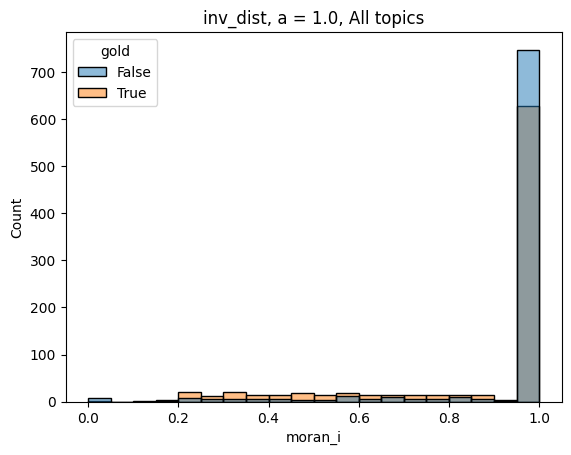

In [10]:
import gradio as gr

def plot_gold_density(w_function_name: str, w_function_param: int):
    # create a new plot
    global topic_data
    global docs_data
    global topic_docs_coordinates
    global topic_candidate_document_matrix

    df = topic_data.copy()

    f_map = {
      "Inverse": inv_dist,
      "Exponential": exp_dist,
      "Arccot": arc_dist,
    }

    w_function = f_map[w_function_name]

    process_geo_associations_for_topics(df, 
                                        docs_data,
                                        topic_candidate_document_matrix,
                                        doc_coordinate_data = topic_docs_coordinates,
                                        w_function = w_function, 
                                        w_function_param = w_function_param, 
                                        save_cache=False)

    # select d45 - document coordinates are more clustered
    # select d57 - document coordinates are spread
    d45 = IndexSlice['d45', :]
    d57 = IndexSlice['d57', :]

    plt.rcParams['figure.figsize'] = (6.4, 4.8)
    
    fig1 = plt.figure(1)
    fig1.add_subplot(
        plot_dist(df, d45, title=f"{w_function.__name__}, a = {w_function_param}, d45")
    )

    fig2 = plt.figure(2)
    fig2.add_subplot(
        plot_dist(df, d57, title=f"{w_function.__name__}, a = {w_function_param}, d57")
    )
    

    fig3 = plt.figure(3)
    fig3.add_subplot(
        plot_dist(df, IndexSlice[:, :], title=f"{w_function.__name__}, a = {w_function_param}, All topics")
    )

    return fig1, fig2, fig3

# show the results

with gr.Blocks() as demo:
    with gr.Row():
        w_function_name = gr.Radio(["Inverse",  "Exponential", "Arccot"], value="Inverse", label = "Similarity transformation function")
        a_slider = gr.Number(value=1.0, info="Input 'a' parameter value, default 1.", label="a")
        #a_slider = gr.Slider(0, 20000, value=1, label="gamma", info="Choose betwen 0 and 1000")

        inputs = [w_function_name, a_slider]
        submit_btn = gr.Button("Submit")

    with gr.Row():
        # outputs = [gr.Gallery(label="Profiling").style(grid=(1,3))]
        outputs = [gr.Plot() for _ in range(3)]
    
    submit_btn.click(
        plot_gold_density,
        inputs,
        outputs,
    )

#demo = gr.Interface(fn=plot_gold_density, inputs=[lambda_slicer, gamma_slicer], outputs=outputs)

demo.launch(debug=True)

# Preprocess Doc coordinate Dataframe

In [ ]:
experiment = "MKDUC01"

topic_coordinates = pd.DataFrame()

for filename in get_files(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, experiment)):
    topic_id = filename[:3]

    if topic_id in ["d08",  # errors
            "d14",
            "d22",
            "d28",
            "d34",
            "d50",
            "d53",
            "d59",]:
            logger.info(f"Skiping topic {topic_id} processing.")
            continue
    
    docs_locations = pd.DataFrame.from_dict(
        {k: {"lat_long": v} 
              for k, v in load_topic_geo_locations(topic_id).items()
        }, 
        orient='index').explode("lat_long")
    
    docs_locations.index.name = "doc"
    docs_locations["topic"] = topic_id
    docs_locations = docs_locations.set_index(["topic", docs_locations.index])

    topic_coordinates = pd.concat( [ topic_coordinates, docs_locations ] )


topic_coordinates.to_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, "MKDUC01-topic-doc-coordinates-20230329.parquet"))
topic_coordinates.head()

In [ ]:
topic_docs_coordinates = pd.read_parquet(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, "MKDUC01-topic-doc-coordinates-20230329.parquet"))

In [ ]:
topic_docs_coordinates

lat_long
topic doc                                  
d56   AP881126-0007    [43.00035, -75.4999]
      AP881126-0007          [-42.0, 174.0]
      AP881126-0007  [-33.86785, 151.20732]
      AP881126-0007          [-25.0, 135.0]
      AP890313-0198          [23.0, -102.0]
...                                     ...
d04   FT923-6455      [31.25044, -99.25061]
      FT923-6455      [32.75041, -86.75026]
      FT923-6455      [30.68515, -88.19753]
      FT923-6455     [41.54357, -109.85903]
      FT923-6455      [25.04082, -77.37122]

[1418 rows x 1 columns]